# QCNN性能测试1

In [1]:
import numpy as np
import mindspore as ms
from mindspore.dataset import NumpySlicesDataset
from mindspore.train.callback import LossMonitor, Callback
from sklearn.model_selection import train_test_split
from src.dataset import build_dataset
from src.qcnn import QCNNet
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

## 1.收敛性

#### 以N=8为例

In [2]:
N = 8
path = './TFI_chain/closed/'
encoder, encoder_params_name, x, y = build_dataset(N, path, 5)
x.shape

(481, 8)

In [3]:
from mindspore.train.callback import Callback
class StepAcc(Callback):
    def __init__(self, model, test_x, test_y):
        self.model = model
        self.test_x = test_x
        self.test_y = test_y.flatten()
        self.acc = []

    def step_end(self, run_context):
        pred_y = self.model.predict(self.test_x)
        self.acc.append((self.test_y == pred_y).mean())

In [4]:
batch = 30
epoch = 4
ms.set_seed(1202)
model = QCNNet(N, encoder)
y = y.reshape((y.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True)
train_loader = NumpySlicesDataset({'features': X_train, 'labels': y_train}, shuffle=False).batch(batch)
monitor = LossMonitor(1)
acc = StepAcc(model, X_test, y_test)
callbacks=[monitor, acc]
model.train(epoch, train_loader, callbacks)

epoch: 1 step: 5, loss is 0.5881807208061218
epoch: 1 step: 10, loss is 0.5801161527633667
epoch: 2 step: 2, loss is 0.5679389238357544
epoch: 2 step: 7, loss is 0.5537038445472717
epoch: 2 step: 12, loss is 0.5645183324813843
epoch: 3 step: 4, loss is 0.5807085037231445
epoch: 3 step: 9, loss is 0.552368700504303
epoch: 4 step: 1, loss is 0.5609754323959351
epoch: 4 step: 6, loss is 0.5470817685127258
epoch: 4 step: 11, loss is 0.5167479515075684


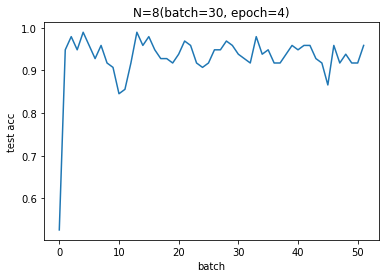

In [11]:
# 测试集acc变化曲线
import matplotlib.pyplot as plt
plt.plot(range(len(acc.acc)), acc.acc)
plt.xlabel('batch')
plt.ylabel('test acc')
plt.title('N=8(batch=30, epoch=4)')
plt.show()

## 2.精度

#### N=4

In [12]:
N = 4
path = './TFI_chain/closed/'
encoder, encoder_params_name, x, y = build_dataset(N, path, 5)
model = QCNNet(N, encoder)
model.load_trained_parameters(f'model_N{N}.ckpt')

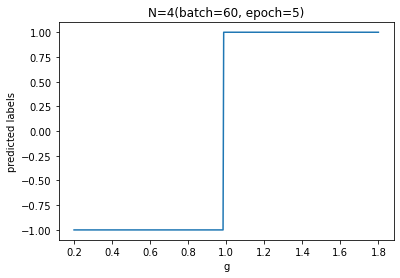

In [15]:
pred_y = model.predict(x)
plt.plot(np.linspace(0.2,1.8,481), pred_y)
plt.title('N=4(batch=60, epoch=5)')
plt.ylabel('predicted labels')
plt.xlabel('g')
plt.show()

#### N=8

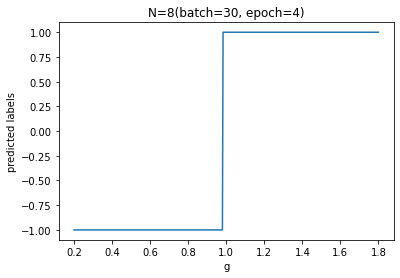

In [16]:
N = 8
path = './TFI_chain/closed/'
encoder, encoder_params_name, x, y = build_dataset(N, path, 5)
model = QCNNet(N, encoder)
model.load_trained_parameters(f'model_N{N}.ckpt')
pred_y = model.predict(x)
plt.plot(np.linspace(0.2,1.8,481), pred_y)
plt.title('N=8(batch=30, epoch=4)')
plt.ylabel('predicted labels')
plt.xlabel('g')
plt.show()

#### N=12

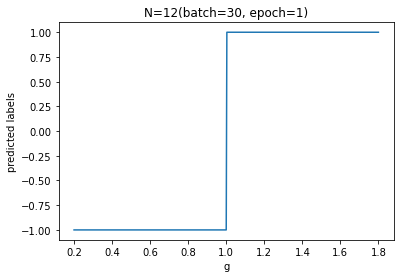

In [17]:
N = 12
path = './TFI_chain/closed/'
encoder, encoder_params_name, x, y = build_dataset(N, path, 5)
model = QCNNet(N, encoder)
model.load_trained_parameters(f'model_N{N}.ckpt')
pred_y = model.predict(x)
plt.plot(np.linspace(0.2,1.8,481), pred_y)
plt.title('N=12(batch=30, epoch=1)')
plt.ylabel('predicted labels')
plt.xlabel('g')
plt.show()

## 3.结论

QCNN有能力对波函数对应的“相位”给出正确预测的能力。